In [1]:
import numpy as np
import torch
import torch.nn as nn
from model import *
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time 

In [2]:
model_pickle = Model()
model_pickle.load_pretrained_model()

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 =nn.Conv2d(3,100,kernel_size=(3,3),stride=(2,2),padding=(1,1))
        self.r1 = nn.ReLU()
        self.c2= nn.Conv2d(100,100,kernel_size=(3,3),stride=(2,2),padding=(1,1))
        self.r2 = nn.ReLU()
        self.u1 = nn.Upsample(scale_factor=2,mode='nearest')
        self.c3 =nn.Conv2d(100,100,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.r3 = nn.ReLU()
        self.u2 = nn.Upsample(scale_factor=2,mode='nearest')
        self.c4 = nn.Conv2d(100,3,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.s = nn.Sigmoid()


    def forward(self, x):
        x = self.c1(x)
        x = self.r1(x)
        x = self.c2(x)
        x = self.r2(x)
        x = self.u1(x)
        x = self.c3(x)
        x = self.r3(x)
        x = self.u2(x)
        x = self.c4(x)
        x = self.s(x)
        
        return x

class Dataset(torch.utils.data.Dataset): 
  'Characterizes a dataset without data augmentatio for PyTorch'
  def __init__(self, train_input, train_target):
        'Initialization'
        x, y = train_input, train_target
        if x.max() > 1: #if the data is not normalized, we devided the values by 255.
            x, y = x / 255, y / 255
        self.x = x.float()
        self.y = y.float()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # get label
        X_trans = self.x[index]
        Y_trans= self.y[index]

        return X_trans, Y_trans



In [7]:
model = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) 
epochs = 1

train_input, train_target = torch.load("/Users/Anya48/Documents/GitHub/Deep_learning_mini_projects/Project1/train_data.pkl")
BATCH_SIZE = 100
train_set = Dataset(train_input, train_target) 
loader_1 = torch.utils.data.DataLoader(dataset = train_set,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)


time_start = time.time()
for epoch in range(epochs):
    print("epoch : ", epoch)
    for noisy_imgs_1, noisy_imgs_2 in loader_1:
        noisy_imgs_1 = noisy_imgs_1.to(device)
        noisy_imgs_2 = noisy_imgs_2.to(device)
        reconstructed = model(noisy_imgs_1)
            
        # Calculating the loss function
        loss = criterion(reconstructed, noisy_imgs_2)
            
        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if time.time() - time_start > 9*60:
        break

PATH = "model_compare.pth"
torch.save(model.state_dict(), PATH)
  

def validate(x,y_test,model):
        a = model(x)
        mse = torch.mean((a - y_test) ** 2)
        return -10 * torch.log10(mse + 10**-8)

epoch :  0


KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt 

def psnr(denoised, ground_truth):
    # Peak Signal to Noise Ratio: denoised and ground ̇truth have range [0, 1] 
    mse = torch.mean((denoised - ground_truth) ** 2)
    return -10 * torch.log10(mse + 10**-8)
    
class SSIM(nn.Module):
    def __init__(self, max_val = 1.):
        super(SSIM, self).__init__()
        self.max_val = max_val
        #window of size 7 x 7 
        window = torch.tensor([[0.0013, 0.0041, 0.0079, 0.0099, 0.0079, 0.0041, 0.0013],
        [0.0041, 0.0124, 0.0241, 0.0301, 0.0241, 0.0124, 0.0041],
        [0.0079, 0.0241, 0.0470, 0.0587, 0.0470, 0.0241, 0.0079],
        [0.0099, 0.0301, 0.0587, 0.0733, 0.0587, 0.0301, 0.0099],
        [0.0079, 0.0241, 0.0470, 0.0587, 0.0470, 0.0241, 0.0079],
        [0.0041, 0.0124, 0.0241, 0.0301, 0.0241, 0.0124, 0.0041],
        [0.0013, 0.0041, 0.0079, 0.0099, 0.0079, 0.0041, 0.0013]])
        self.kernel = window.repeat(3, 1, 1, 1) #repeat the window on the 3 channels

        self.C1 = (0.01 * self.max_val) ** 2
        self.C2 = (0.03 * self.max_val) ** 2

    def forward(self, groundtruth, noisy_img): 
        kernel = self.kernel.to(groundtruth.device).to(noisy_img.dtype)
        mu1 = F.conv2d(groundtruth, kernel, groups = 3)
        mu2 = F.conv2d(noisy_img, kernel, groups = 3)

        mu1_square = mu1.pow(2)
        mu2_square = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_square =  F.conv2d(groundtruth * groundtruth, kernel, groups = 3) - mu1_square
        sigma2_square =  F.conv2d(noisy_img * noisy_img, kernel, groups = 3) - mu2_square
        sigma12 =  F.conv2d(groundtruth * noisy_img, kernel, groups = 3) - mu1_mu2

        ssim = ((2 * mu1_mu2 + self.C1)*(2 * sigma12 + self.C2)) / ((mu1_square + mu2_square + self.C1) * (sigma1_square + sigma2_square + self.C2))

        loss = 1-ssim
        loss = torch.mean(loss)

        return loss


def ssim(ground_truth, noisy_img, max_val = 1.):
    return SSIM(max_val = max_val)(ground_truth , noisy_img)


def compare_models(models, names = None, SIZE = 1000):
    # Given a list PATHS of PATH (str) that leads to a model in the corresponding list models,
    # display a noisy image, its ground truth and the denoised images and compute the PSNR over SIZE images of the test set.
    BATCH_SIZE = 1
    test_input, test_target = torch.load("/Users/Anya48/Documents/GitHub/Deep_learning_mini_projects/Project1/val_data.pkl")
    test_set = Dataset(test_input, test_target)
    loader_1 = torch.utils.data.DataLoader(dataset = test_set,
                                     batch_size = BATCH_SIZE,
                                     shuffle = False)
    #number of images to plot
    N = (len(models) + 3)//2
    plt.figure(figsize = (4 * N, 9))
    rand_int = np.random.randint(low = 0, high = 1000)
    print("random image to save : ", rand_int)
    for j, model in enumerate(models):
        PSNR = torch.empty(size = (1, SIZE))
        SSIMs = torch.empty(size = (1, SIZE))
        i = 0
        for noisy_imgs, ground_truth in loader_1:
            if j == 0: 
                denoised = model.predict(noisy_imgs*255)/255
            else :
                denoised = model(noisy_imgs).detach()
            PSNR[0, i] = psnr(denoised, ground_truth)
            SSIMs[0, i] = 1-ssim(ground_truth, denoised)
            if i == rand_int :
              denoised_plot = denoised
              if j==0:
                ground_truth_plot = ground_truth
                noisyimg_plot = noisy_imgs
            i += 1
        meanPSNR = torch.mean(PSNR).item()
        meanSSIM = torch.mean(SSIMs).item()
        print("Model ", j, " PSNR:", meanPSNR) #display the mean of PSNR over the test set.
        print("Model ", j, " SSIM:", meanSSIM)
        if j%2 == 0:
            plt.subplot(2, N, j//2 + 2)
        else :
            plt.subplot(2, N, j//2 + N + 2)
        plt.imshow(torch.squeeze(denoised_plot).permute(1, 2, 0))
        if names != None:
            plt.title(names[j] + '\nmean PSNR: ' + str(round(meanPSNR, 4))) # + '\nmean SSIM: ' + str(round(meanSSIM, 4)))
        else:
            plt.title("model " + str(j))
    
    plt.subplot(2, N, 1)
    plt.imshow(torch.squeeze(noisyimg_plot).permute(1, 2, 0)) #int since the data has been changed to float for the NN.
    plt.title("Noisy image")
    plt.subplot(2, N, N + 1)
    plt.imshow(torch.squeeze(ground_truth_plot).permute(1, 2, 0))
    plt.title("Groundtruth")
    plt.savefig('Comparison_' + str(len(models)) + '_models')
    plt.show()

In [5]:
PATH = "model_compare.pth"
model = Net()
model.load_state_dict(torch.load(PATH))

models = [model_pickle, model]
names = ["Our implementation", "Pytorch implementation"]

random image to save :  732
Model  0  PSNR: 23.1589412689209
Model  0  SSIM: 0.7391983270645142
Model  1  PSNR: 22.975065231323242
Model  1  SSIM: 0.7360546588897705


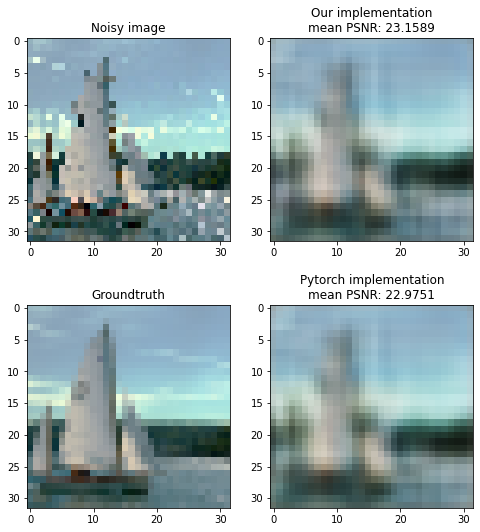

In [6]:
compare_models(models, names)
